In [1]:
import os
kaggle_auth = {"username":"kaggleusername","key":"kagglekey"}
os.environ['KAGGLE_USERNAME'] = kaggle_auth["username"]
os.environ['KAGGLE_KEY'] = kaggle_auth["key"]
!kaggle datasets download preetviradiya/brian-tumor-dataset
!pip install timm
!pip install matplotlib
!pip install torcheval

brian-tumor-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
# Importing all the needed libraries
import timm
from fastcore.all import *
from fastai.vision.all import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
from torcheval.metrics import MulticlassAccuracy, BinaryAUPRC, BinaryPrecision, BinaryRecall
import gc

In [3]:
# Extracting data from the zip file
with zipfile.ZipFile('brian-tumor-dataset.zip', 'r') as zip_ref:
  zip_ref.extractall()

In [4]:
# Constants
BATCH_SIZE = 64  # Batch size for training
NUM_OF_EPOCHS = 10  # Number of epochs for training
MODEL_NAME = "efficientnet_b0"  # Name of the pretrained model
base_model_output_size = 1280  # Output size of the base model
LEARNING_RATE = 0.001  # Learning rate for optimization
DROPOUT_PROB = 0.3  # Dropout probability for regularization
DATASET_PATH = "Brain Tumor Data Set/Brain Tumor Data Set"  # Path to the dataset
IMG_HEIGHT_WIDTH = 128  # Height and width of input images

In [5]:
# Define a custom dataset class for the brain tumor dataset
class BrainTumorDataset(Dataset):
  def __init__(self, data_directory, transform=None):
    self.data = ImageFolder(data_directory, transform=transform)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    return self.data[index]

  @property
  def classes(self):
    return self.data.classes

In [16]:
# Define image transformations
transform = transforms.Compose([transforms.Resize((IMG_HEIGHT_WIDTH, IMG_HEIGHT_WIDTH)), transforms.ToTensor()])

# Create an instance of the dataset
dataset = BrainTumorDataset(Path(DATASET_PATH), transform)

# Create a dictionary mapping indexes to classes
indexes_to_classes = {v: k for k, v in ImageFolder(Path(DATASET_PATH)).class_to_idx.items()}

# Retrieve a sample image and label from the dataset
for image, label in dataset:
  break

# Display the shape of the image
image.shape # [image_dimensions, image_height, image_width]

torch.Size([3, 128, 128])

In [7]:
# Create a dataloader for the dataset
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Retrieve a batch of images and labels from the dataloader
for images, labels in dataloader:
  break

# Display the shapes of the batched images and labels
images.shape, labels.shape # [batch_size, image_dimensions, image_height, image_width]

(torch.Size([64, 3, 128, 128]), torch.Size([64]))

In [8]:
# Define a class for a pretrained fine-tuned CNN for brain tumor classification
class BrainTumorClassifierPreTrainedFineTunedCNN(nn.Module):
  def __init__(self, number_of_classes):
    super(BrainTumorClassifierPreTrainedFineTunedCNN, self).__init__()

    # Load the base model and modify its last layer
    self.base_model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=0)

    # making our last layer (the classifier)
    self.classifier =  nn.Sequential(nn.Dropout(p=DROPOUT_PROB), nn.Linear(base_model_output_size, number_of_classes))

  def forward(self, x):
    # Forward pass through the model
    x = self.base_model(x)
    output = self.classifier(x)
    return output

In [9]:
# Define a class for a CNN for brain tumor classification without pretraining
class BrainTumorClassifierNotPreTrainedFineTunedCNN(nn.Module):
  def __init__(self, number_of_classes):
    super(BrainTumorClassifierNotPreTrainedFineTunedCNN, self).__init__()

    # Load the base model and modify its last layer
    self.base_model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=0)

    # making our last layer (the classifier)
    self.classifier =  nn.Sequential(nn.Dropout(p=DROPOUT_PROB), nn.Linear(base_model_output_size, number_of_classes))

  def forward(self, x):
    # Forward pass through the model
    x = self.base_model(x)
    output = self.classifier(x)
    return output

In [10]:
# Define a class for a custom CNN for brain tumor classification
class BrainTumorClassifierCNN(nn.Module):
  def __init__(self, number_of_classes):
    super(BrainTumorClassifierCNN, self).__init__()

    # Define the layers of the CNN
    self.layer1 = nn.Conv2d(3, 8, stride=2, kernel_size=3)
    self.layer1_norm = nn.BatchNorm2d(8)
    self.layer1_activation = nn.ReLU()

    self.layer2 = nn.Conv2d(8, 16, stride=2, kernel_size=3)
    self.layer2_norm = nn.BatchNorm2d(16)
    self.layer2_activation = nn.ReLU()

    self.layer3 = nn.Conv2d(16, 32, stride=2, kernel_size=3)
    self.layer3_norm = nn.BatchNorm2d(32)
    self.layer3_activation = nn.ReLU()

    self.layer4 = nn.Conv2d(32, 2, stride=2, kernel_size=3)
    self.layer5 = nn.Flatten()

  def forward(self, x):
    # Connect these parts and return the output
    layer1_output = self.layer1_activation(self.layer1_norm(self.layer1(x)))
    layer2_output = self.layer2_activation(self.layer2_norm(self.layer2(layer1_output)))
    layer3_output = self.layer3_activation(self.layer3_norm(self.layer3(layer2_output)))
    layer4_output = self.layer4(layer3_output)
    output = self.layer5(layer4_output)
    return output

In [11]:
# Define a class for a multilayer perceptron (MLP) for brain tumor classification
class BrainTumorClassifierMLP(nn.Module):
  def __init__(self, number_of_classes):
    super(BrainTumorClassifierMLP, self).__init__()
    inital_input_size = 3 * IMG_HEIGHT_WIDTH * IMG_HEIGHT_WIDTH
    inital_output_size = IMG_HEIGHT_WIDTH // 3
    self.first_linear = nn.Linear(inital_input_size, inital_output_size)
    self.first_layer_activation = nn.ReLU()
    self.second_linear = nn.Linear(inital_output_size, inital_output_size//4)
    self.second_layer_activation = nn.ReLU()
    self.third_linear = nn.Linear(inital_output_size//4, inital_output_size//8)
    self.third_layer_activation = nn.ReLU()
    self.fourth_linear = nn.Linear(inital_output_size//8, number_of_classes)

  def forward(self, x):
    # Connect the parts and return the output
    x = x.view(x.size(0), -1)
    first_layer = self.first_linear(x)
    first_activation = self.first_layer_activation(first_layer)
    second_layer = self.second_linear(first_activation)
    second_activation = self.second_layer_activation(second_layer)
    third_layer = self.third_linear(second_activation)
    third_activation = self.third_layer_activation(third_layer)
    output = self.fourth_linear(third_activation)
    return output

In [12]:
# Define a class for a linear regression model for brain tumor classification
class BrainTumorClassifierLinearRegression(nn.Module):
  def __init__(self, number_of_classes):
    super(BrainTumorClassifierLinearRegression, self).__init__()

    self.linear =  nn.Linear((3 * IMG_HEIGHT_WIDTH * IMG_HEIGHT_WIDTH), number_of_classes)

  def forward(self, x):
    # Connect the parts and return the output
    x = x.view(x.size(0), -1)
    output = self.linear(x)
    return output

In [13]:
# Create instances of the defined models
models = [BrainTumorClassifierPreTrainedFineTunedCNN(len(indexes_to_classes)), BrainTumorClassifierNotPreTrainedFineTunedCNN(len(indexes_to_classes)), BrainTumorClassifierCNN(len(indexes_to_classes)), BrainTumorClassifierMLP(len(indexes_to_classes)), BrainTumorClassifierLinearRegression(len(indexes_to_classes))]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [14]:
# Determine the device for training (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Start trainging model: BrainTumorClassifierPreTrainedFineTunedCNN
Base line loss: 0.709, accuracy: 0.49782609939575195, precision: 0.40689656138420105, recall: 0.6666666865348816, auprc: 0.3995252251625061
Epoch 1/10 - Train loss: 0.149, Validation loss: 0.152
Train acc - 0.9442934989929199, valid acc - 0.9413043260574341
Epoch 2/10 - Train loss: 0.052, Validation loss: 0.041
Train acc - 0.980163037776947, valid acc - 0.9760869741439819
Epoch 3/10 - Train loss: 0.038, Validation loss: 0.051
Train acc - 0.987500011920929, valid acc - 0.9869565367698669
Epoch 4/10 - Train loss: 0.025, Validation loss: 0.048
Train acc - 0.991576075553894, valid acc - 0.9760869741439819
Epoch 5/10 - Train loss: 0.017, Validation loss: 0.023
Train acc - 0.9942934513092041, valid acc - 0.989130437374115
Epoch 6/10 - Train loss: 0.014, Validation loss: 0.008
Train acc - 0.9970108866691589, valid acc - 0.9934782385826111
Epoch 7/10 - Train loss: 0.006, Validation loss: 0.079
Train acc - 0.997826099395752, vali

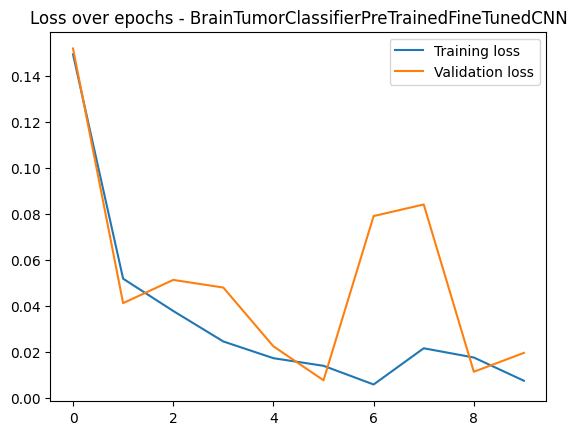




Start trainging model: BrainTumorClassifierNotPreTrainedFineTunedCNN
Base line loss: 0.694, accuracy: 0.4434782564640045, precision: 0.4434782564640045, recall: 1.0, auprc: 0.4434782564640045
Epoch 1/10 - Train loss: 0.543, Validation loss: 0.381
Train acc - 0.7342391014099121, valid acc - 0.834782600402832
Epoch 2/10 - Train loss: 0.193, Validation loss: 0.253
Train acc - 0.9334239363670349, valid acc - 0.893478274345398
Epoch 3/10 - Train loss: 0.103, Validation loss: 0.125
Train acc - 0.9641304612159729, valid acc - 0.960869550704956
Epoch 4/10 - Train loss: 0.042, Validation loss: 0.175
Train acc - 0.9842391014099121, valid acc - 0.936956524848938
Epoch 5/10 - Train loss: 0.029, Validation loss: 0.152
Train acc - 0.991032600402832, valid acc - 0.947826087474823
Epoch 6/10 - Train loss: 0.021, Validation loss: 0.187
Train acc - 0.9934782385826111, valid acc - 0.9521738886833191
Epoch 7/10 - Train loss: 0.052, Validation loss: 0.152
Train acc - 0.981521725654602, valid acc - 0.954

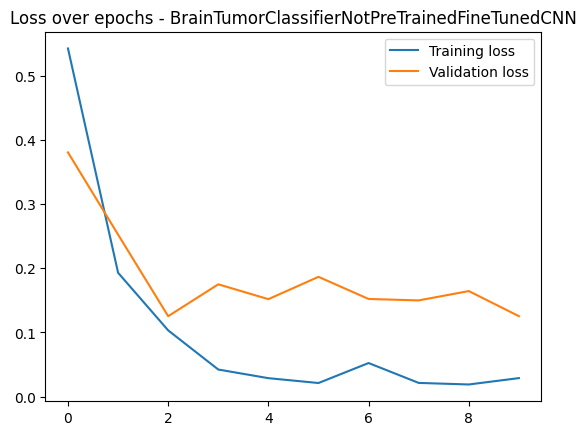




Start trainging model: BrainTumorClassifierCNN
Base line loss: 4.554, accuracy: 0.20217391848564148, precision: 0.43491125106811523, recall: 0.7424242496490479, auprc: 0.4544280171394348
Epoch 1/10 - Train loss: 1.981, Validation loss: 1.391
Train acc - 0.4744565188884735, valid acc - 0.5347825884819031
Epoch 2/10 - Train loss: 1.196, Validation loss: 1.183
Train acc - 0.5883151888847351, valid acc - 0.5586956739425659
Epoch 3/10 - Train loss: 1.027, Validation loss: 1.078
Train acc - 0.6298912763595581, valid acc - 0.6217391490936279
Epoch 4/10 - Train loss: 0.904, Validation loss: 0.929
Train acc - 0.6733695864677429, valid acc - 0.647826075553894
Epoch 5/10 - Train loss: 0.802, Validation loss: 0.856
Train acc - 0.719565212726593, valid acc - 0.656521737575531
Epoch 6/10 - Train loss: 0.735, Validation loss: 0.773
Train acc - 0.7464674115180969, valid acc - 0.708695650100708
Epoch 7/10 - Train loss: 0.643, Validation loss: 0.727
Train acc - 0.7861412763595581, valid acc - 0.72826

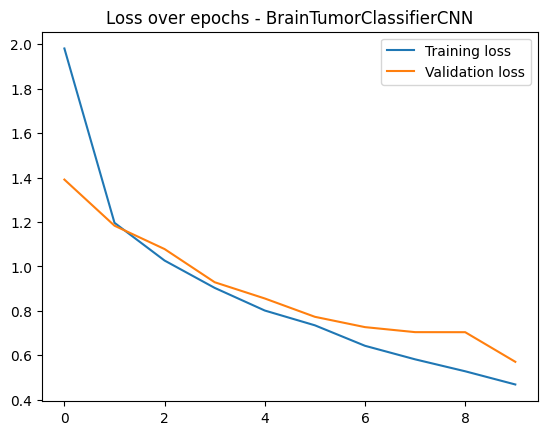




Start trainging model: BrainTumorClassifierMLP
Base line loss: 0.693, accuracy: 0.5130434632301331, precision: 0.0, recall: 0.0, auprc: 0.48695650696754456
Epoch 1/10 - Train loss: 0.673, Validation loss: 0.579
Train acc - 0.63451087474823, valid acc - 0.741304337978363
Epoch 2/10 - Train loss: 0.546, Validation loss: 0.499
Train acc - 0.739945650100708, valid acc - 0.782608687877655
Epoch 3/10 - Train loss: 0.475, Validation loss: 0.468
Train acc - 0.7961956262588501, valid acc - 0.77173912525177
Epoch 4/10 - Train loss: 0.425, Validation loss: 0.409
Train acc - 0.823913037776947, valid acc - 0.8369565010070801
Epoch 5/10 - Train loss: 0.363, Validation loss: 0.451
Train acc - 0.8611413240432739, valid acc - 0.8086956739425659
Epoch 6/10 - Train loss: 0.299, Validation loss: 0.340
Train acc - 0.9021739363670349, valid acc - 0.876086950302124
Epoch 7/10 - Train loss: 0.253, Validation loss: 0.312
Train acc - 0.917934775352478, valid acc - 0.876086950302124
Epoch 8/10 - Train loss: 0

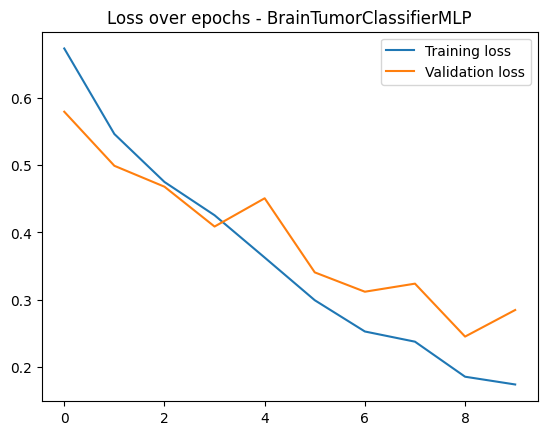




Start trainging model: BrainTumorClassifierLinearRegression
Base line loss: 0.711, accuracy: 0.40869563817977905, precision: 0.39889195561408997, recall: 0.7236180901527405, auprc: 0.4082106649875641
Epoch 1/10 - Train loss: 2.128, Validation loss: 0.636
Train acc - 0.615217387676239, valid acc - 0.6913043260574341
Epoch 2/10 - Train loss: 0.456, Validation loss: 0.442
Train acc - 0.800543487071991, valid acc - 0.832608699798584
Epoch 3/10 - Train loss: 0.483, Validation loss: 0.408
Train acc - 0.801902174949646, valid acc - 0.8173912763595581
Epoch 4/10 - Train loss: 0.402, Validation loss: 0.501
Train acc - 0.835326075553894, valid acc - 0.760869562625885
Epoch 5/10 - Train loss: 0.437, Validation loss: 0.651
Train acc - 0.8168478012084961, valid acc - 0.780434787273407
Epoch 6/10 - Train loss: 0.308, Validation loss: 0.335
Train acc - 0.8817934989929199, valid acc - 0.8695651888847351
Epoch 7/10 - Train loss: 0.310, Validation loss: 0.363
Train acc - 0.883695662021637, valid acc 

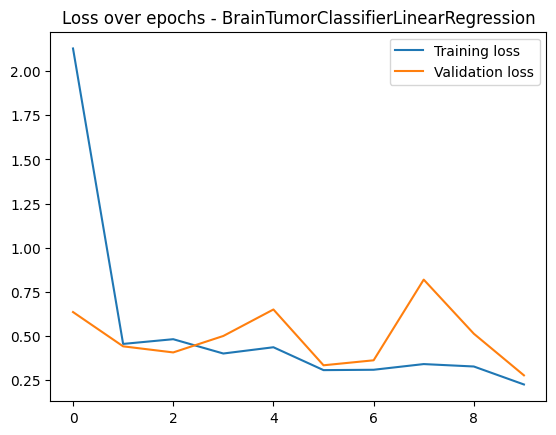

In [15]:
# Iterate over each model for training
for model in models:
  print(f"Start trainging model: {type(model).__name__}")

  # Define the loss function
  loss_function = nn.CrossEntropyLoss()

  # Define the optimizer
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

  # Split the dataset into training, validation, and test sets
  training_set_length = (int) (len(dataset) * 0.8)
  validation_set_length = (int) (len(dataset) * 0.1)
  test_set_length = (len(dataset)) - training_set_length - validation_set_length

  training_set, validation_set, test_set = torch.utils.data.random_split(dataset, [training_set_length, validation_set_length, test_set_length])

  # Create dataloaders for training, validation, and test sets
  training_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
  validation_loader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False)
  test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

  # Lists to store training and validation losses
  train_losses, val_losses = [], []

  # Move the model to the chosen device
  model.to(device)

  # Evaluation metrics for baseline model evaluation
  base_line_loss = []
  base_line_metric = MulticlassAccuracy()
  base_line_auprc = BinaryAUPRC()
  base_line_precision = BinaryPrecision()
  base_line_recall = BinaryRecall()

  # Set the model to evaluation mode
  model.eval()
  base_line_running_loss = 0.0

  # Perform evaluation on validation data
  with torch.no_grad():
    for images, labels in validation_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = loss_function(outputs, labels)
      base_line_metric.update(outputs.argmax(1), labels)
      base_line_auprc.update(outputs.argmax(1), labels)
      base_line_precision.update(outputs.argmax(1), labels)
      base_line_recall.update(outputs.argmax(1), labels)
      base_line_running_loss += loss.item() * images.size(0)

  base_line_loss = base_line_running_loss / len(validation_loader.dataset)

  # Print baseline evaluation metrics
  print(f"Base line loss: {base_line_loss:.3f}, accuracy: {base_line_metric.compute()}, precision: {base_line_precision.compute()}, recall: {base_line_recall.compute()}, auprc: {base_line_auprc.compute()}")

  # Training loop
  for epoch in range(NUM_OF_EPOCHS):

    # Set the model to training mode
    model.train()
    train_metric = MulticlassAccuracy()
    valid_metric = MulticlassAccuracy()

    # Training phase in the epoch
    running_loss = 0.0
    for images, labels in training_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = loss_function(outputs, labels)
      train_metric.update(outputs.argmax(1), labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(training_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase in the epoch
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in validation_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = loss_function(outputs, labels)
          valid_metric.update(outputs.argmax(1), labels)
          running_loss += loss.item() * images.size(0)

    validation_loss = running_loss / len(validation_loader.dataset)
    val_losses.append(validation_loss)

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{NUM_OF_EPOCHS} - Train loss: {train_loss:.3f}, Validation loss: {validation_loss:.3f}")
    print(f"Train acc - {train_metric.compute()}, valid acc - {valid_metric.compute()}")

  # Evaluation on test set
  auprc = BinaryAUPRC()
  precision = BinaryPrecision()
  recall = BinaryRecall()
  test_accuracy = MulticlassAccuracy()
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_function(outputs, labels)
        valid_metric.update(outputs.argmax(1), labels)
        auprc.update(outputs.argmax(1), labels)
        precision.update(outputs.argmax(1), labels)
        recall.update(outputs.argmax(1), labels)
        test_accuracy.update(outputs.argmax(1), labels)
        running_loss += loss.item() * images.size(0)

  test_loss = running_loss / len(test_loader.dataset)
  print(f"\nTest loss: {test_loss:.3f}")
  print(f"accuracy - {test_accuracy.compute()} auprc - {auprc.compute()}, precision - {precision.compute()}, recall - {recall.compute()}")


  # Plot training and validation losses
  plt.plot(train_losses, label='Training loss')
  plt.plot(val_losses, label='Validation loss')
  plt.legend()
  plt.title(f"Loss over epochs - {type(model).__name__}")
  plt.show()

  # Clear GPU cache and perform garbage collection
  torch.cuda.empty_cache()
  gc.collect()
  print("\n\n")